In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
from pymatgen import units

from scipy.constants import Boltzmann, electron_volt
from sympy import symbols
from sympy.vector import CoordSys3D

import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from ruamel.yaml import YAML
yaml = YAML()

from neighbormodels.structure import from_file
from neighbormodels.neighbors import count_neighbors
from neighbormodels.interactions import build_model
import neighbormodels as nm

kB = 1000 * Boltzmann / electron_volt

pd.set_option("display.colheader_justify", "left")
pd.set_option("display.html.border", 0)
html_table_style = {"selector": "th", "props": [("text-align", "left")]}

In [96]:
#codes I need
def drop_duplicate_energies(qe_energies):
    """
    Checks that energies are unique (not within tolerance value of each other)
    
    Parameters:
    
    qe_energies - list of energ values (read from file)
    
    """
    qe_energies.columns = ["pattern", "num_sites", "total_energy" ]
    ryd_to_ev = 13.605693009 #eV 
    tol = 0.0001 #eV

    #convert to eV
    qe_energies["total_energy"] = qe_energies["total_energy"]*ryd_to_ev

    for i in range(len(qe_energies)-1):
        for j in range(1+1,len(qe_energies)):
            if (i != j):
                diff = abs(qe_energies["total_energy"][i] - qe_energies["total_energy"][j])
                if (  diff  <= tol ):
                    qe_energies["pattern"][j] = qe_energies["pattern"][i]
                    #print (i,j, qe_energies["total_energy"][i], qe_energies["total_energy"][j], diff)
                
                
    #drop repeating energies            
    qe_energies = qe_energies.reset_index(drop=True).drop_duplicates(["pattern"], keep="first")           
 
    #convert back to Rydberg
    qe_energies["total_energy"] = qe_energies["total_energy"]/ryd_to_ev
    
    return qe_energies

def mg_moments_check(mg_moments, qe_energies):
    
    """
    Checks for no lost magnetic moments
    
    Parameters:
    
    mg_moments - table of magnetic moments read from file
    qe_energies - table of energies read from file
    
    """
    n_row, n_column = mg_moments.shape
    mg_moments = pd.DataFrame(round (abs(mg_moments/4.0)).sum(axis=0), columns=["total_moment"])
    mg_moments = pd.concat ([qe_energies['pattern'], mg_moments['total_moment']], axis=1)
    
    return mg_moments[(mg_moments['total_moment'] != n_row ) & (mg_moments['pattern'] != "nm") ] #.head()

In [63]:
#structure files:
cif_filepath1 = "data/mn8au16_collinear.cif"
cif_filepath2 = "data/mn8au16_1x1x4.cif"
structure_mnau2_c = from_file(structure_file=cif_filepath1)
structure_mnau2_z = from_file(structure_file=cif_filepath2)

#drop the Au from structures
c_struc = structure_mnau2_c.copy()
z_struc = structure_mnau2_z.copy()
c_struc.remove_species(["Au"])
z_struc.remove_species(["Au"])

#read in distances list with related patterns
distances_list=pd.read_csv('data/distances')

/home/ssilayi/anaconda3/lib/python3.6/site-packages/pymatgen/core/lattice.py:694: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(q.T, p.T)[0].T


In [64]:
def pattern_tables( layer, p_type):
    """
    Places magnetic patterns in the correct order 
    relative to the structure file.
    
    Parameters:
    
    layer - magnetic patterns read in from file
    p_type - pre-fix for pattern
    
    """
    n_row, n_column = layer.shape
    
    patterns = pd.concat([layer], ignore_index=True)
    
    p_types =[]
    p_types.append("nm")
    index = np.arange(1,len(patterns.columns))
    for i in index:
        p_types.append(p_type+str(i))
    patterns.columns = p_types
    
    return patterns


c_layer=pd.read_csv('data/mg_collinear_patterns', header=None)
c_patterns = pattern_tables( c_layer, "c-")
z_layer=pd.read_csv('data/mg_1x1x4_patterns', header=None)
z_patterns = pattern_tables( z_layer, "z-")

In [65]:
neighbor_data_c = count_neighbors(cell_structure=c_struc, r=18.0)
neighbor_data_z = count_neighbors(cell_structure=z_struc, r=18.0)

In [83]:
#create dictionaries from distances list for build model input
distances = {"c": list(distances_list.c), "z" :list(distances_list.z)}

In [94]:
exchange_model_c = build_model(magnetic_patterns=c_patterns, 
                                neighbor_data=neighbor_data_c, 
                                  distance_filter = distances )

exchange_model_z = build_model(magnetic_patterns=z_patterns, 
                                neighbor_data=neighbor_data_z, 
                                  distance_filter = distances)

exchange_model = pd.concat([exchange_model_c, exchange_model_z])\
                     .reset_index(drop=True)
exchange_model

In [117]:
#Calculated energies from QE for the different patterns are tabulated and read in
qe_energies1 = pd.read_csv('data/energy.out.collinear.csv', header=None)
qe_energies_c = drop_duplicate_energies(qe_energies1) 

qe_energies2 = pd.read_csv('data/energy.out.1x1x4.csv', header=None)
qe_energies_z = drop_duplicate_energies(qe_energies2)    

#combine all energies
qe_energies = pd.concat([qe_energies_c, qe_energies_z])
qe_energies = qe_energies.reset_index(drop=True).drop_duplicates(["pattern"], keep="first") 
qe_energies

/home/ssilayi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,pattern,num_sites,total_energy
0,nm,24,-14691.879405
1,c-1,24,-14693.951620
2,c-2,24,-14693.957454
3,c-3,24,-14693.970500
4,c-4,24,-14693.947722
5,c-5,24,-14693.946375
6,c-6,24,-14693.953194
7,c-7,24,-14693.949463
8,c-8,24,-14693.941122
9,c-9,24,-14693.932390


In [100]:
#read in magnetic moments and return any that don't have the expected total magnetic moment (24)
mg_moments_c = pd.read_csv('data/mg_moment.collinear',sep='\t', header=None)
zero_moments_c = mg_moments_check(mg_moments_c, qe_energies_c)
#zero_moments_c

mg_moments_z = pd.read_csv('data/mg_moment.1x1x4',sep='\t', header=None)
zero_moments_z = mg_moments_check(mg_moments_z, qe_energies_z)
#zero_moments_z

In [118]:
def ModelMatrix(qe_energies, exchange_model):
    model_matrix = qe_energies \
        .assign(energy = lambda x:
            (x["total_energy"] -
             np.float64(x.query("pattern == 'c-15'").loc[:, "total_energy"])) *
            1000 * units.Ry_to_eV / x["num_sites"])  \
        .merge(exchange_model, on=["pattern"]) \
        .query("pattern != 'nm'") \
        .query("pattern != 'c-15'") \
        .assign(J1 = lambda x: x["Jc1"]) \
        .assign(J2 = lambda x: x["Jc2"]) \
        .assign(J3 = lambda x: x["Jc3"]) \
        .assign(J4 = lambda x: x["Jc4"]) \
        .assign(J5 = lambda x: x["Jz1"]) \
        .assign(J6 = lambda x: x["Jz2"]) \
        .assign(J7 = lambda x: x["Jz3"]) \
        .assign(J8 = lambda x: x["Jz4"]) \
        .loc[:, ["pattern", "energy", "J1", "J2", "J3", "J4", "J5" , "J6", "J7","J8"]]

    return model_matrix

model_matrix = ModelMatrix(qe_energies, exchange_model)\
               .reset_index(drop=True) \
               .drop(["pattern"], axis=1) 

model_matrix.head()

,energy,J1,J2,J3,J4,J5,J6,J7,J8
0,23.519612,0.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
1,20.212521,1.0,0.0,0.0,2.0,3.0,0.0,3.0,2.0
2,12.816852,2.0,2.0,2.0,4.0,5.0,1.0,5.0,2.0
3,25.729856,-2.0,2.0,2.0,-4.0,1.0,1.0,1.0,2.0
4,26.493193,-1.0,0.0,0.0,-2.0,1.0,0.0,1.0,2.0


In [119]:
#fit for paramters
lm = LinearRegression()
lm_exchange_fit = lm.fit(X=model_matrix[["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]], y=model_matrix["energy"])
lm_exchange_parameters = pd.DataFrame({
    "sklearn": [lm_exchange_fit.intercept_, 
                lm_exchange_fit.coef_[0], lm_exchange_fit.coef_[1],lm_exchange_fit.coef_[2],
                lm_exchange_fit.coef_[3], lm_exchange_fit.coef_[4],lm_exchange_fit.coef_[5],
                lm_exchange_fit.coef_[6], lm_exchange_fit.coef_[7]]},
    index=["Intercept", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"],
)
lm_exchange_parameters

,sklearn
Intercept,26.231429
J1,-0.521892
J2,-0.779431
J3,-1.975920
J4,-1.043784
J5,-0.442842
J6,-1.135446
J7,0.297568
J8,0.239164


### Cross Validation

In [120]:
data = model_matrix.copy()
data.head()

#check the values of energies predicted from the sk_fit parameters vs. the starting values:
parameters = ["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
energy_predict = pd.DataFrame()
energy_predict["energy_calc"] = data.energy 
for i in range(1, 9):
    pars_to_fit = parameters[:i]    
    sk_fit = lm.fit(X=data[pars_to_fit], y=data.energy)
    energy_predict[f"energy_{i}"] = sk_fit.predict(data[pars_to_fit])
    
energy_predict.head()

,energy_calc,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8
0,23.519612,26.117367,24.067719,24.210604,24.210604,24.064025,24.568781,24.770552,24.860349
1,20.212521,20.891791,21.944313,24.110993,24.110993,23.666340,23.428944,23.631629,23.664478
2,12.816852,15.666215,15.554003,15.470448,15.470448,14.129109,13.409201,14.019745,14.118324
3,25.729856,36.568520,32.581435,25.416035,25.416035,25.353975,25.162487,25.154120,25.137255
4,26.493193,31.342943,30.458029,29.083787,29.083787,29.278773,29.305587,29.198817,29.173944


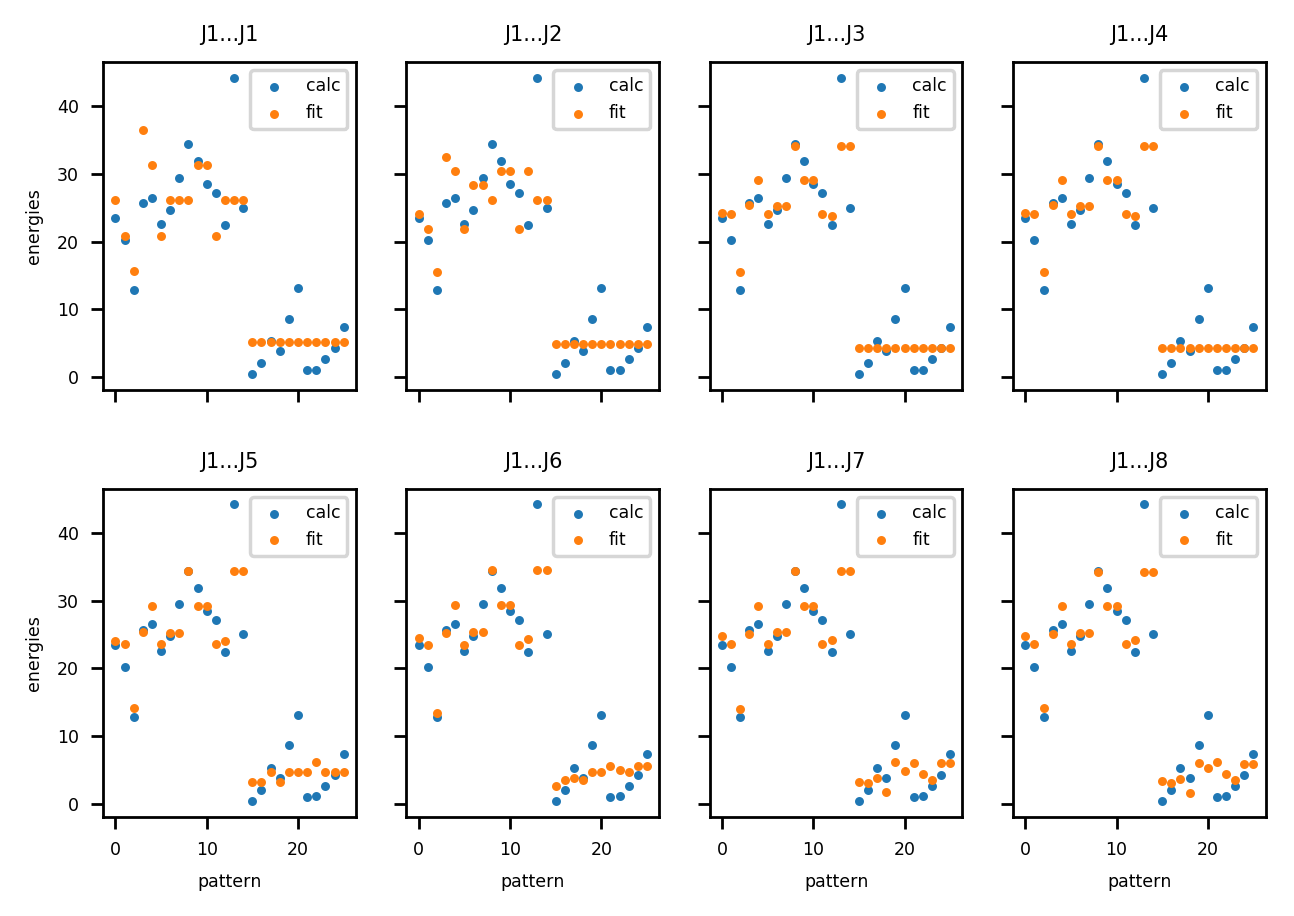

In [121]:
plt.rcParams.update({'font.size': 5})
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', dpi=250)
fig.subplots_adjust(hspace=0.3)
k = 1
for i in range(2):
    for j in range(4):
        p_e = "energy_"+str(k)
        J = "J" + str(1)+"...J"+str(k)
        ax[i, j].scatter(x= range(len(data) ), y="energy_calc", data=energy_predict, label = "calc", s=2.5)
        ax[i, j].scatter(x= range(len(data) ), y=p_e, data=energy_predict, label = "fit", s=2.5)
        ax[i, j].set_title(J)
        ax[i, j].set(xlabel='pattern', ylabel='energies')
        ax[i, j].legend()
        k = k+1
        
for aij in ax.flat:
    aij.label_outer()

#### Loop over  different number of J parameters, use repeated k-fold cross validation to score the models: k = 4, repeats = 100

In [130]:
#checking for reasonable k (settled for 4)
from sklearn.model_selection import KFold
parameters = np.array([1,2,3,4,5,6,7,8])

#for i in range(10):
kfold = KFold(8, True, 1)
# enumerate splits
for train, test in kfold.split(parameters):
    print('train: %s, test: %s' % (parameters[train], parameters[test]))

train: [1 2 3 4 5 6 7], test: [8]
train: [1 2 4 5 6 7 8], test: [3]
train: [1 3 4 5 6 7 8], test: [2]
train: [1 2 3 4 5 6 8], test: [7]
train: [2 3 4 5 6 7 8], test: [1]
train: [1 2 3 4 6 7 8], test: [5]
train: [1 2 3 5 6 7 8], test: [4]
train: [1 2 3 4 5 7 8], test: [6]


In [133]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
lm = LinearRegression()

scores = {
    "n": [],
    "mse_trace": [],
    "mse_mean": [],
    "mse_sd": [],
    "r**2_trace": [],
    "r**2_mean": [],
    "r**2_sd": [],
}

parameters = ["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
energy_predict = pd.DataFrame()
energy_predict["energy_calc"] = data.energy 
for n in range(1, 9):
    x = data[parameters[:n]]    
    y = data.energy
    
    rkf = RepeatedKFold(
        n_splits=8,
        n_repeats=100,
        random_state=int(np.round(np.random.uniform(0, 2**31), decimals=0)),
    )
    
    # Cross-validated mean-squared error score
    mse_cv_score = cross_val_score(
        lm,
        x, y,
        scoring="neg_mean_squared_error",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )
    
     # Cross-validated R**2 score
    r2_cv_score = cross_val_score(
        lm,
        x, y,
        scoring="r2",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )
    
    scores["n"].append(n)
    scores["mse_trace"].append(mse_cv_score)
    scores["mse_mean"].append(np.mean(mse_cv_score))
    scores["mse_sd"].append(np.std(mse_cv_score))
    scores["r**2_trace"].append(r2_cv_score)
    scores["r**2_mean"].append(np.mean(r2_cv_score))
    scores["r**2_sd"].append(np.std(r2_cv_score))


##### Model performance scores

In [132]:
n_par_scores = pd.DataFrame(scores)
n_par_scores[["n", "mse_mean", "mse_sd", "r**2_mean", "r**2_sd"]]

,n,mse_mean,mse_sd,r**2_mean,r**2_sd
0,1,-36.727360,33.749578,0.360303,2.968390
1,2,-41.861545,35.797774,0.036880,7.502778
2,3,-23.900297,20.333783,0.576194,2.739115
3,4,-25.006159,21.221669,0.597565,1.183301
4,5,-26.384508,21.767728,0.606288,1.700349
5,6,-29.410354,22.750454,0.502893,1.662363
6,7,-30.535398,24.075759,0.530109,1.263721
7,8,-41.536736,29.543928,0.128108,2.624549
